# Summary
Trying to explore some features in the frequency domain.

### Reference:
* [EDA on the frequency domain (FFT)](https://www.kaggle.com/aperezhortal/eda-on-the-frequency-domain-fft)

In [1]:
import os
print(os.listdir("../input"))

['test', 'train.csv', 'sample_submission.csv']


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt

from scipy import signal # for fft
from numpy import fft
from tqdm import tqdm_notebook# progress bar

In [3]:
# bokeh visualization for spectrum analysis
from bokeh.layouts import column, row
from bokeh.plotting import figure, show, output_file, ColumnDataSource
from bokeh.io import output_notebook
from bokeh.models import LinearAxis, Range1d, CustomJS, Slider, PrintfTickFormatter

output_notebook() # Display Bokeh plots inline

Loading BokehJS ...

In [4]:
%%time
train = pd.read_csv('../input/train.csv', 
                    dtype={'acoustic_data': np.int16, 
                           'time_to_failure': np.float32})

CPU times: user 2min 21s, sys: 26 s, total: 2min 47s
Wall time: 2min 48s


In [5]:
rows = 150000
num_segments = int(np.floor(train.shape[0] / rows))
dt = 0.0375/rows
# sampling_frequency is the upper bound of the frequency
sampling_frequency = np.ceil(1/dt)
print("Total {0:d} segments, time step {1:.3e} seconds, sampling frequency {2:.0f}hz."\
      .format(num_segments, dt, sampling_frequency) )

Total 4194 segments, time step 2.500e-07 seconds, sampling frequency 4000000hz.


# Power spectrum estimation
`scipy.signal`'s [periodogram](https://docs.scipy.org/doc/scipy-0.13.0/reference/generated/scipy.signal.periodogram.html) uses [Welch's method in the code](https://github.com/scipy/scipy/blob/v0.13.0/scipy/signal/spectral.py#L141) to estimate the power spectrum of a time signal, which is applying FFT on a real signal with a rolling averaging window. The function used in Welch's method is [fftpack.rfft](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fftpack.rfft.html).

Reference: P. Welch, "The use of the fast Fourier transform for theestimation of power spectra: A method based on time averaging over short, modified periodograms", IEEE Trans. Audio            Electroacoust. vol. 15, pp. 70-73, 1967.

In [6]:
# sampling_frequency is the upper bound of the frequency
sampling_frequency = np.ceil(1/dt)

def get_spectrum(input_signal, window=10):
    """
    returns the Fourier power spectrum for a given signal segment
    output is a pandas Series 
    output.index is the frequencies
    output.values is the amplitudes for each frequencies
    default moving average window is 10
    """
    input_signal = np.asarray(input_signal.values, dtype='float64')
    
    # Remove the mean  
    input_signal -= input_signal.mean()  
    
    # Estimate power spectral density using a periodogram.
    frequencies , power_spectrum = signal.periodogram(
        input_signal, sampling_frequency, scaling='spectrum')    
    
    # Run a running windows average of 10-points to smooth the signal (default). 
    power_spectrum = pd.Series(power_spectrum, index=frequencies).rolling(window=window).mean()        
    
    return pd.Series(power_spectrum)

def get_segment_spectrum(segment_df, 
                         max_frequency = 300000, min_frequency = 100,
                         step = 10, window = 10):
    """
    get the Fourier power spectrum of a given segment.
    returns the quake_time, frequencies, and power_spectrum
    """
    
    quake_time = segment_df['time_to_failure'].values[-1]
#     quake_time = segment_df['time_to_failure'].values[-5000:].mean()
    
    _power_spectrum = get_spectrum(segment_df['acoustic_data'], window=window).dropna() 
    # drop the null values

    # Keep only frequencies < max_frequency (larger frequencies have a negligible contribution).
    # and > min_frequency (some low frequency is outlier)
    _power_spectrum = _power_spectrum[_power_spectrum.index < max_frequency]
    _power_spectrum = _power_spectrum[_power_spectrum.index > min_frequency]
    
    # Keep one every 10 samples by default
    power_spectrum=_power_spectrum.values[::step]
    frequencies=_power_spectrum.index.values[::step]    
    
    return quake_time, frequencies, power_spectrum

# Some examples

## Example around 1st earthquake 
Explanations of the functions above, first the frequency power spectrum for this segment is obtained through
* Smoothened data using a 10-points rolling window;
* Keeping one every 10 samples;
* Keeping only frequencies < 350khz and > 100hz.


In [7]:
# this is the segment that has the first earth quake, length = 150000
first_quake_time = 5656574
window = 10
segment = train.iloc[first_quake_time-rows//2:first_quake_time+rows//2]
x_tr = np.asarray(segment['acoustic_data'].values, dtype='float64')
x_tr -= x_tr.mean()

frequencies , power_spectrum_1 = signal.periodogram(x_tr, sampling_frequency, scaling='spectrum')    

power_spectrum_1 = pd.Series(power_spectrum_1, index=frequencies)
power_spectrum_1 = power_spectrum_1.rolling(window=window).mean().dropna()

In [8]:
# for this segment the time_to_failure
max_frequency = 350000
quake_time = segment['time_to_failure'].values[-1]
power_spectrum_1 = power_spectrum_1[power_spectrum_1.index < max_frequency]

## Explore the power spectrum of the first segment

Reference: [Bokeh gallery](https://bokeh.pydata.org/en/latest/docs/gallery.html)

In [9]:
# Bokeh tooltips
# "@foo{(0.00 a)}" # formats 1230974 as: 1.23 m
TOOLTIPS = [ ("x", "@x{(0 a)}Hz"), ("y", "$y")   ]

In [10]:
freq1 = power_spectrum_1.index
spec1 = power_spectrum_1.values

pl1 = figure(plot_width=750, plot_height=400,title="Power spectrum of 1 segment",tooltips=TOOLTIPS)
pl1.line(freq1, spec1)
pl1.xaxis[0].formatter = PrintfTickFormatter(format="%d")
pl1.xaxis.axis_label = "Frequency"
pl1.yaxis.axis_label = "Power (L^2 norm squared)"
show(pl1)

In [11]:
window_tmp = 100
freq2 = power_spectrum_1.index
spec2 = power_spectrum_1.rolling(window=window_tmp).mean()

pl2 = figure(plot_width=750, plot_height=400,
             title=f"Power spectrum of 1 segment (sampling {100/step}% data)",tooltips=TOOLTIPS)
pl2.line(freq2, spec2)
pl2.xaxis[0].formatter = PrintfTickFormatter(format="%d")
pl2.xaxis.axis_label = "Frequency"
pl2.yaxis.axis_label = "Power (L^2 norm squared)"
show(pl2)

NameError: name 'step' is not defined

# Retrieving the power spectrum for all segments

In [12]:
## perform above for all segments
# since the frequencies retrieved is changing, initialization is none
window = 20
step = 5
quake_times = np.array([])       
power_spectrums = np.array([])
max_frequency = 350000
min_frequency = 100

for k in tqdm_notebook(range(num_segments)):
    segment = train.iloc[k*rows : k*rows+rows]
    quake_time, frequencies, power_spectrum = \
    get_segment_spectrum(segment, 
                         max_frequency=max_frequency,
                         min_frequency=min_frequency,
                         step=step,window=window)    
    quake_times = np.append(quake_times, quake_time)
    power_spectrums = np.append(power_spectrums, power_spectrum)
    
power_spectrums = power_spectrums.reshape(num_segments,-1)
quake_times = quake_times.reshape(num_segments,-1)

In [13]:
power_spectrums.shape

(4194, 2622)

In [14]:
frequencies.size

2622

In [15]:
window = 5

normalized_spectrums = power_spectrums/(np.sum(power_spectrums, axis=1)[:,np.newaxis])
# since power_spectrums are already L^2 norm squared
# normalization is done for each row by dividing its total energy for total 4194 rows

average_power_spectrum = pd.Series(np.mean(normalized_spectrums,axis=0)) # average all 4194 spectrum
average_power_spectrum = average_power_spectrum.rolling(window=window).mean()

In [16]:
pl = figure(plot_width=750, plot_height=400,title=f"Normalized average power spectrum with rolling window {window}",
            tooltips=TOOLTIPS)
pl.line(frequencies, average_power_spectrum)
pl.xaxis[0].formatter = PrintfTickFormatter(format="%d")
pl.xaxis.axis_label = "Frequency"
pl.yaxis.axis_label = "Normalized Power"
show(pl)

On average, the normalized energy has 5 local maximum around 5 peaks among the following frequency ranges.

Hovering the mouse on the diagram can reveal the values of the coordinates.

* 45-60 khz
* 80-100 khz
* 130-150khz 
* 165-185khz
* 230-270khz

In [17]:
freq_intervals = np.array([0, 7e3, 5e4, 1e5])

In [18]:
frequencies.max()

349973.3333333334

In [19]:
train_X_fft = pd.DataFrame(index=range(num_segments), dtype=np.float64)

In [20]:
for seg_id in tqdm_notebook(range(num_segments)):
    train_X_fft.loc[seg_id, 'energy_mean_in_7khz'] = \
    normalized_spectrums[seg_id, frequencies<7e3].mean()
    train_X_fft.loc[seg_id, 'energy_mean_in_50khz_100khz'] = \
    normalized_spectrums[seg_id, (frequencies>5e4) & (frequencies<1e5)].mean()
    train_X_fft.loc[seg_id, 'energy_mean_in_130khz_150khz'] = \
    normalized_spectrums[seg_id, (frequencies>1.3e5) & (frequencies<1.5e5)].mean()
    train_X_fft.loc[seg_id, 'energy_mean_in_165khz_185khz'] = \
    normalized_spectrums[seg_id, (frequencies>1.65e5) & (frequencies<1.85e5)].mean()
    train_X_fft.loc[seg_id, 'energy_mean_in_230khz'] = \
    normalized_spectrums[seg_id, (frequencies>2.3e5)].mean()
    
    train_X_fft.loc[seg_id, 'energy_q90_in_7khz'] = \
    np.quantile(normalized_spectrums[seg_id, frequencies<7e3], 0.9)
    train_X_fft.loc[seg_id, 'energy_q90_in_50khz_100khz'] = \
    np.quantile(normalized_spectrums[seg_id, (frequencies>5e4) & (frequencies<1e5)], 0.9)
    train_X_fft.loc[seg_id, 'energy_q90_in_130khz_150khz'] = \
    np.quantile(normalized_spectrums[seg_id, (frequencies>1.3e5) & (frequencies<1.5e5)], 0.9)
    train_X_fft.loc[seg_id, 'energy_q90_in_165khz_185khz'] = \
    np.quantile(normalized_spectrums[seg_id, (frequencies>1.65e5) & (frequencies<1.85e5)], 0.9)
    train_X_fft.loc[seg_id, 'energy_q90_in_230khz'] = \
    np.quantile(normalized_spectrums[seg_id, (frequencies>2.3e5)], 0.9)

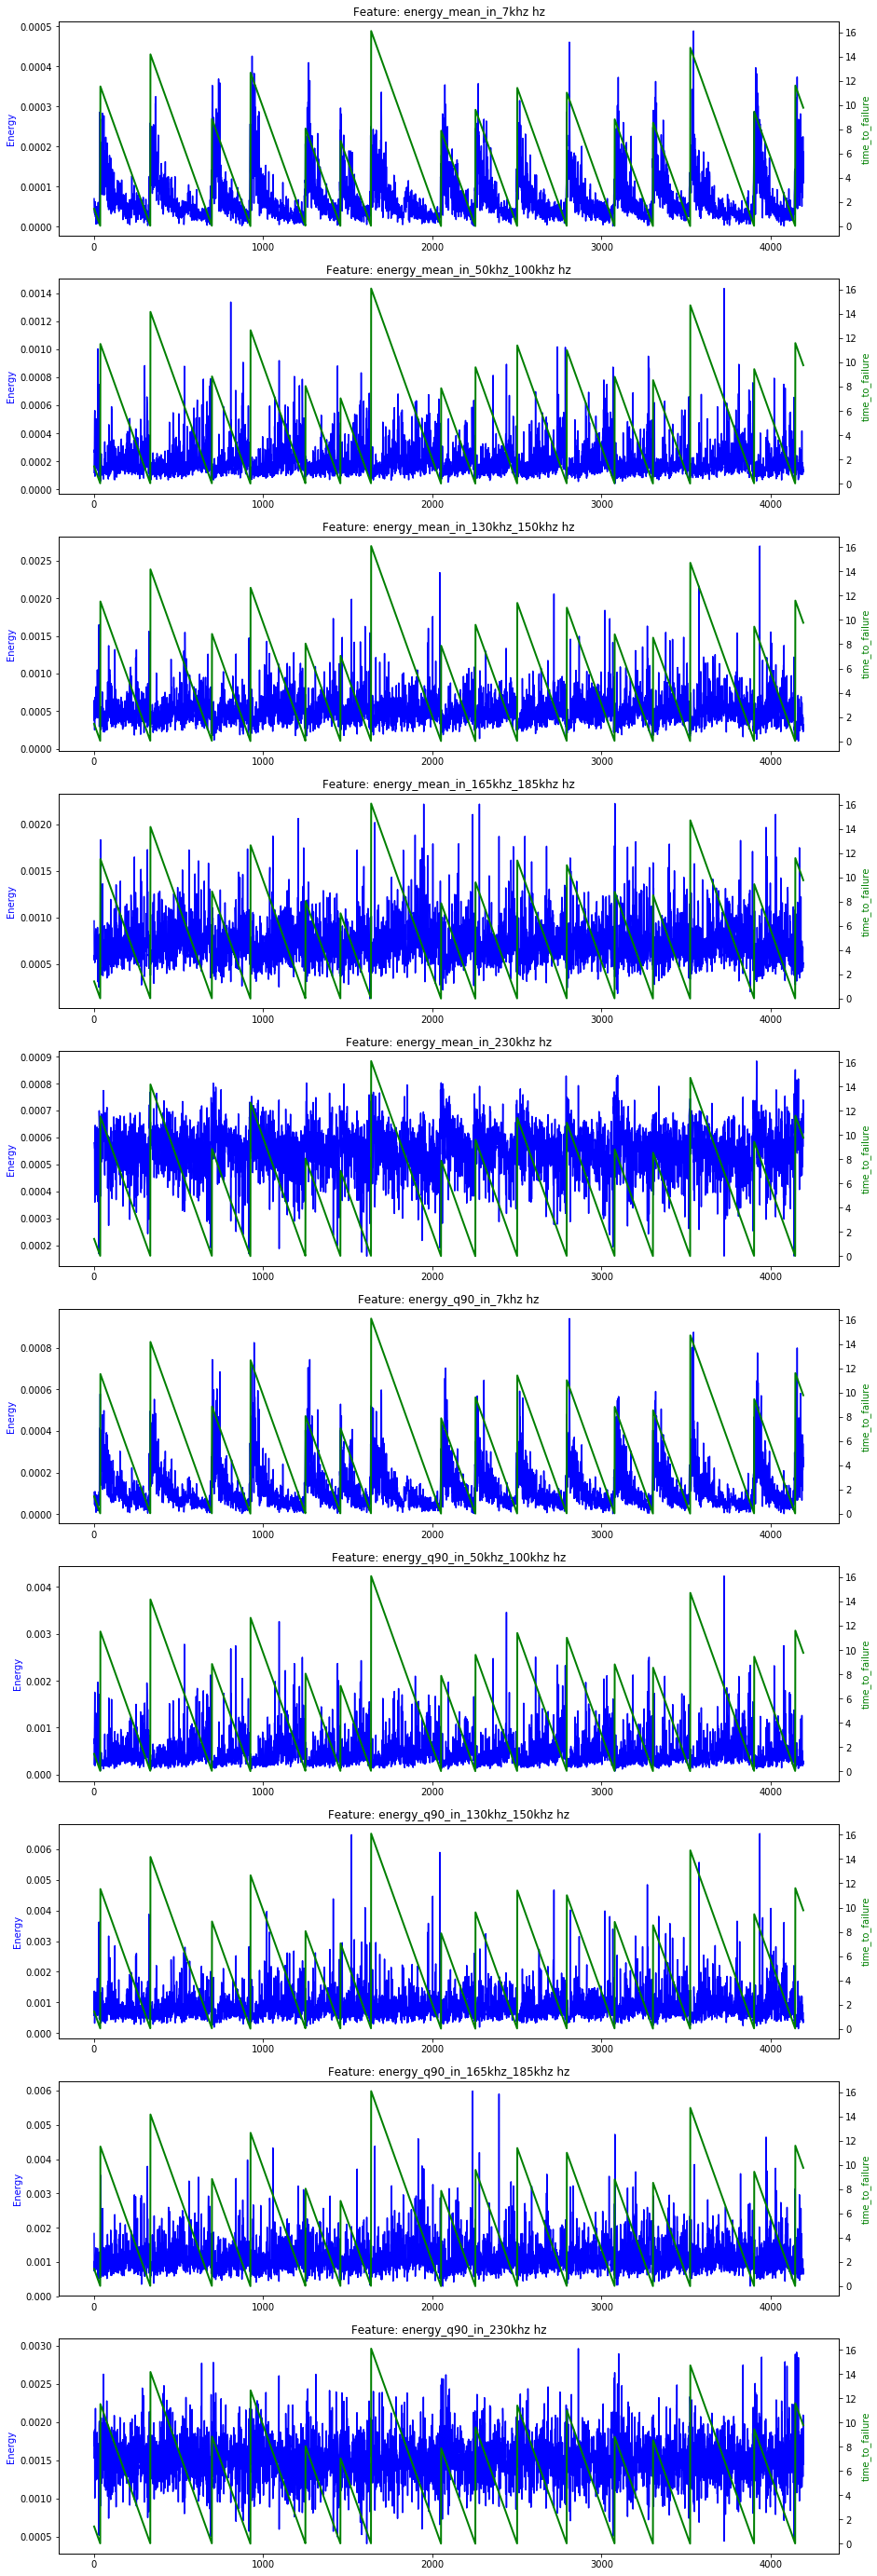

In [21]:
num_freq = train_X_fft.shape[1]
_, ax1 = plt.subplots(num_freq,1, figsize=(15,5*num_freq))
ax1 = ax1.reshape(-1)

for i, col in enumerate(train_X_fft.columns):
    ax1[i].plot(train_X_fft[col], color='blue')
    ax1[i].set_title("Feature: {:s} hz".format(col))
    ax1[i].set_ylabel("Energy", color='b')

    ax2 = ax1[i].twinx()
    ax2.plot(quake_times, color='g', linewidth = 2)
    ax2.set_ylabel('time_to_failure', color='g')
    ax2.grid(False)

# Visualizing energy vs time_to_failure for all segments

We try to explore `time_to_failure`'s relation to the spectrum. First `time_to_failure` is divided into intervals. We look at the average spectrum for the segments of which the `time_to_failure` falls into the range. 

In [22]:
Dt = dt*(50085878-5656574)/20  # Interval of time to aggregate a composite
max_quake_time = quake_times.max()
quake_times_intervals = np.arange(Dt/2, max_quake_time+Dt/2+0.01, Dt/4)
num_freq = frequencies.size
num_intervals = quake_times_intervals.size
print("The compositite spectrum is analyzed for %d time_to_failure intervals, has %d frequencies." 
      %(num_intervals,num_freq))

The compositite spectrum is analyzed for 117 time_to_failure intervals, has 2622 frequencies.


In [23]:
composite_spectrums_mean = np.zeros((num_intervals, num_freq))
composite_spectrums_std = np.zeros((num_intervals, num_freq))
composite_spectrums_min = np.zeros((num_intervals, num_freq))
composite_spectrums_max = np.zeros((num_intervals, num_freq))


The normalized spectrum can be used as features of all the segments.

In [24]:
for n , quake_time in enumerate(quake_times_intervals):
#     t0 = quake_time-Dt/2
#     t1 = quake_time+Dt/2
    t0 = quake_time-Dt*0.75 # overlapping
    t1 = quake_time+Dt*0.75
    segments = ((quake_times>=t0) & (quake_times<t1)).reshape(-1)
    if len(segments) > 0:
        # averaging the spectra for those who fall into the same quake time interval
        composite_spectrums_mean[n] = normalized_spectrums[segments,:].mean(axis=0)
        composite_spectrums_std[n] = normalized_spectrums[segments,:].std(axis=0)
        composite_spectrums_min[n] = normalized_spectrums[segments,:].min(axis=0)
        composite_spectrums_max[n] = normalized_spectrums[segments,:].max(axis=0)
        
_quake_time = quake_times_intervals[0]

In [25]:
pl = figure(plot_width=800, plot_height=400, 
            title= f"Avg spectra for {_quake_time-Dt*3/4} <= time_to_failure < {_quake_time+Dt*3/4}",
            y_range=(0, 3e-3), tooltips=TOOLTIPS)

data_dict = dict()
for i in range(quake_times_intervals.size):    
    data_dict[str(i)] = composite_spectrums_mean[i]

all_data = ColumnDataSource(data=data_dict)
source = ColumnDataSource(data=dict(frequencies=frequencies, 
                                    composite_mean=composite_spectrums_mean[0]))

pl.line('frequencies', 'composite_mean', source=source)
pl.xaxis[0].formatter = PrintfTickFormatter(format="%d")
pl.xaxis.axis_label = "Frequency"
pl.yaxis.axis_label = "Normalized Power (L^2-norm squared)"

                            
callback = CustomJS(args=dict(source=source, 
                              all_data=all_data,plot=pl,
                              quake_times_intervals=quake_times_intervals,
                              Dt=Dt), 
                    code="""
    var data = source.data;
    var interval = slider.value;
    var composite_means = all_data.data[String(interval)];    
    var y = data['composite_mean']
    for (var i = 0; i < y.length; i++) {
        y[i] = composite_means[i];
    }
    var _quake_time = quake_times_intervals[interval]
    console.log(String(_quake_time-Dt*3/4));
    console.log(String(_quake_time+Dt*3/4));
    plot.title.text = String("Avg spectra for "+(_quake_time-Dt*3/4).toFixed(3)) + " <= time_to_failure < " + String((_quake_time+Dt*3/4).toFixed(3));
    source.change.emit();
""")

time_slider = Slider(start=0, end=composite_spectrums_mean.shape[0], value=0, step=1,
                     title="Quaketime interval number", callback=callback)
callback.args["slider"] = time_slider
                            
layout = column(time_slider,  pl)
show(layout)

# The power spectrum for subdividing a training segment

Dividing the several training segments (150000 time steps) into sub-segments.

In [26]:
# for random K samples
K = 5
seg_spectrums = np.array([])
# seg_quake_times = np.array([])
segs = np.random.choice(num_segments, size=K, replace=True)

window = 10
sampling_step = 10
num_subsegs = 10
len_subsegs = int(rows/num_subsegs)
for n in tqdm_notebook(segs):
    for k in range(num_subsegs):
        sub_seg = train.iloc[n*num_subsegs+k*len_subsegs : n*num_subsegs+k*len_subsegs+len_subsegs]
        _, frequencies, seg_spectrum = get_segment_spectrum(sub_seg, 
                                                            max_frequency=max_frequency,
                                                            step=sampling_step, window=window)
        seg_spectrums = np.append(seg_spectrums, seg_spectrum)
#         seg_quake_times = np.append(seg_quake_times, seg_quake_time)

In [27]:
seg_spectrums = seg_spectrums.reshape(K*num_subsegs,-1)
normalized_seg_spectrums = seg_spectrums/(np.sum(seg_spectrums, axis=1)[:,np.newaxis])

In [28]:
seg_quake_times = train['time_to_failure'].values[rows::rows]

In [29]:
print(seg_quake_times.shape)

(4194,)


In [30]:
average_seg_spectrum = pd.Series(np.mean(normalized_seg_spectrums,axis=0)) 
# average all 10 sub-segments
average_seg_spectrum = average_seg_spectrum.rolling(window=window).mean()

pl = figure(plot_width=750, plot_height=400,
            title=f"Average power spectrum with rolling window {window} for Segment {segs[0]}",
            tooltips=TOOLTIPS)
pl.line(frequencies, average_seg_spectrum)
pl.xaxis[0].formatter = PrintfTickFormatter(format="%d")
pl.xaxis.axis_label = "Frequency"
pl.yaxis.axis_label = "Normalized Power"
show(pl)

In [31]:
print(normalized_seg_spectrums.shape)
normalized_seg_spectrums = normalized_seg_spectrums.reshape(K,num_subsegs,-1)
print(normalized_seg_spectrums.shape)

(50, 131)
(5, 10, 131)


In [32]:
## plot the subsegment power spectrum
subseg_intervals = np.arange(0, 150000+0.01, len_subsegs)

pl = figure(plot_width=750, plot_height=400, 
            title= f"Training Seg No {segs[0]}: normalized spectrum for {0} <= time step <= {len_subsegs}",
            y_range=(0, 1e-1), tooltips=TOOLTIPS)

data_dict = dict()
for i in range(num_subsegs):    
    data_dict[str(i)] = normalized_seg_spectrums[0,i,:]

all_data = ColumnDataSource(data=data_dict)
source = ColumnDataSource(data=dict(frequencies=frequencies, 
                                    seg_spectrum=normalized_seg_spectrums[0]))

pl.line('frequencies', 'seg_spectrum', source=source)
pl.xaxis[0].formatter = PrintfTickFormatter(format="%d")
pl.xaxis.axis_label = "Frequency"
pl.yaxis.axis_label = "Normalized Power"

                            
callback = CustomJS(args=dict(source=source, 
                              all_data=all_data,plot=pl,
                              subseg_intervals=subseg_intervals,
                              len_subsegs=len_subsegs), 
                    code="""
    var data = source.data;
    var interval = slider.value;
    var seg_spectrum = all_data.data[String(interval)];    
    var y = data['seg_spectrum']
    for (var i = 0; i < y.length; i++) {
        y[i] = seg_spectrum[i];
    }
    var _seg_time = subseg_intervals[interval]
    console.log(String(_seg_time));
    console.log(String(_seg_time+len_subsegs));
    plot.title.text = String("Training Seg No.1: Normalized spectrum for "+(_seg_time).toFixed(0)) + " <= time step <= " + String((_seg_time+len_subsegs).toFixed(0));
    source.change.emit();
""")

time_slider = Slider(start=0, end=num_subsegs, value=0, step=1,
                     title="Sub-segment number", callback=callback)
callback.args["slider"] = time_slider
                            
layout = column(time_slider,  pl)
show(layout)

# The power spectrum for one testing segment

Dividing the first testing segment (150000 time steps) into 10 sub-segments.

In [33]:
submission = pd.read_csv('../input/sample_submission.csv', 
                         index_col='seg_id', 
                         dtype={"time_to_failure": np.float32})

In [34]:
len(submission)

2624

In [35]:
seg_id = submission.index[np.random.randint(len(submission))]
seg_test = pd.read_csv('../input/test/' + seg_id + '.csv')
seg_test['time_to_failure'] = 0

In [36]:
# a random testing sample
seg_spectrums = np.array([])
window = 10
sampling_step = 10
num_subsegs = 10
len_subsegs = int(rows/num_subsegs)

for k in tqdm_notebook(range(num_subsegs)):
    sub_seg = seg_test.iloc[k*len_subsegs : k*len_subsegs+len_subsegs]
    _, frequencies, seg_spectrum = get_segment_spectrum(sub_seg, 
                                                        max_frequency=max_frequency,
                                                        step=sampling_step, window=window)
    seg_spectrums = np.append(seg_spectrums, seg_spectrum)
    
seg_spectrums = seg_spectrums.reshape(num_subsegs,-1)
normalized_seg_spectrums = seg_spectrums/(np.sum(seg_spectrums, axis=1)[:,np.newaxis])

In [37]:
normalized_seg_spectrums.shape

(10, 131)

In [38]:
frequencies.size

131

In [39]:
average_seg_spectrum1 = pd.Series(np.mean(normalized_seg_spectrums[0],axis=0)) 
# average all 10 sub-segments for first sample
average_seg_spectrum1 = average_seg_spectrum.rolling(window=window).mean()
average_seg_spectrum1.shape

(131,)

In [40]:
pl = figure(plot_width=750, plot_height=400,
            title=f"Normalized average spectrum with rolling window {window} for segment {seg_id}",
            tooltips=TOOLTIPS)
pl.line(frequencies, average_seg_spectrum1)
pl.xaxis[0].formatter = PrintfTickFormatter(format="%d")
pl.xaxis.axis_label = "Frequency"
pl.yaxis.axis_label = "Normalized Power"
show(pl)

In [41]:
## plot the subsegment power spectrum
subseg_intervals = np.arange(0, 150000+0.01, len_subsegs)

pl = figure(plot_width=750, plot_height=400, 
            title= f"Testing Seg No.1: normalized spectrum for {0} <= time step <= {len_subsegs}",
            y_range=(0, 1e-1), tooltips=TOOLTIPS)

data_dict = dict()
for i in range(num_subsegs):    
    data_dict[str(i)] = normalized_seg_spectrums[i]

all_data = ColumnDataSource(data=data_dict)
source = ColumnDataSource(data=dict(frequencies=frequencies, 
                                    seg_spectrum=normalized_seg_spectrums[0]))

pl.line('frequencies', 'seg_spectrum', source=source)
pl.xaxis[0].formatter = PrintfTickFormatter(format="%d")
pl.xaxis.axis_label = "Frequency"
pl.yaxis.axis_label = "Normalized Power"

                            
callback = CustomJS(args=dict(source=source, 
                              all_data=all_data,plot=pl,
                              subseg_intervals=subseg_intervals,
                              len_subsegs=len_subsegs), 
                    code="""
    var data = source.data;
    var interval = slider.value;
    var seg_spectrum = all_data.data[String(interval)];    
    var y = data['seg_spectrum']
    for (var i = 0; i < y.length; i++) {
        y[i] = seg_spectrum[i];
    }
    var _seg_time = subseg_intervals[interval]
    console.log(String(_seg_time));
    console.log(String(_seg_time+len_subsegs));
    plot.title.text = String("Testing Seg No.1: Normalized spectrum for "+(_seg_time).toFixed(0)) + " <= time step <= " + String((_seg_time+len_subsegs).toFixed(0));
    source.change.emit();
""")

time_slider = Slider(start=0, end=num_subsegs, value=0, step=1,
                     title="Sub-segment number", callback=callback)
callback.args["slider"] = time_slider
                            
layout = column(time_slider,  pl)
show(layout)